<a href="https://colab.research.google.com/github/TahiriNadia/ML_DL_Classification_Trees/blob/master/src/3D_representations_of_rf_matrices_on_simulated_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Start

In [ ]:
import os
import numpy  as np
import urllib.request as url
from array import *
import random
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

### Load simulated dataset

In [ ]:
# b'20',    b'8',     b'1',       b'0',           b'0'
# nb_arbre, nb_taxon, nb_cluster, percent_noise, nb_eloignement
def mask_cluster (nb_cluster):
    cluster = np.zeros((1,NB_CLUSTERS))
    cluster[0,nb_cluster-1]=1
    return cluster

NB_CLUSTERS=5
NB_DEPTH=5808
NB_N=20

values_i = np.zeros((NB_DEPTH,NB_N,NB_N))
cluster_i = np.zeros((NB_DEPTH,NB_CLUSTERS))
nb_eloignements = np.zeros((NB_DEPTH))
cluster_ii = np.zeros((NB_DEPTH,NB_N,NB_CLUSTERS))

fh = url.urlopen( "https://github.com/TahiriNadia/ML_DL_Classification_Trees/raw/master/data/simulation/simulation_dataset")
depth = 0
l_i = 1

while True:
    ligne = fh.readline()
    nb_arbre,nb_taxon,nb_cluster,percent_noise,nb_eloignement = ligne.split()
    cluster_i[depth]=mask_cluster(int(nb_cluster))
    # cluster_ii[depth]=mask_cluster2(int(nb_cluster), int(nb_arbre))
    nb_eloignements[depth]=nb_eloignement
    for i in range(0, int(nb_arbre)):
        ligne = fh.readline()
        values_i [depth,i,:] = ligne.split()

    ligne = fh.readline()
    depth = depth + 1
    l_i = l_i + int(nb_arbre) + 2
    if not ligne:
      break
fh.close


<bound method HTTPResponse.close of <http.client.HTTPResponse object at 0x7f49cee0b890>>

In [ ]:
def ConditionedSamples(x_values,y_values):
  nonzero = np.squeeze(np.sum(x_values,axis=(1,2))!=0) # indexes of zero matrices
  remoteness_down = (nb_eloignements >= 0)
  remoteness_up = (nb_eloignements < 25)
  remoteness = remoteness_down & remoteness_up
  # only_four = (y_values[:,4]==0)

  Conditioned_Index = nonzero & remoteness #& only_four
  X, y, remotenesses = x_values[Conditioned_Index], y_values[Conditioned_Index], nb_eloignements[Conditioned_Index]
  return X,y, Conditioned_Index

X, y, Conditioned_Index= ConditionedSamples(values_i,cluster_i)


In [ ]:
y.shape

(2105, 5)

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.1
train_x,test_x, train_y, test_y = train_test_split(X,y,test_size=test_size)

## 3D Cubes

In [ ]:
# 6 bins convert into 3D

@tf.function(experimental_relax_shapes=True)
def tf_normalize(tensor):
  tensor=tf.cast(tensor,tf.float32)
  min = tf.reduce_min(tensor)
  return tf.divide( 
      tf.subtract(tensor, min), 
      tf.add(tf.subtract(tf.reduce_max(tensor), min),tf.constant(1e-25,dtype=tf.float32))
      )
  
@tf.function(experimental_relax_shapes=True)
def to_3DCube(rf_matrix, claster_num=-1, length=20): 
  
  New_dims=6 # number "m" in the article
  NBins=tf.constant(New_dims, dtype=tf.int32)
  Value_Range=tf.constant([0.,1.],dtype=tf.float32)

  #length - number "n" in article
  density =10
  # length = rf_matrix.shape[0]
  NBins=tf.constant(New_dims, dtype=tf.int32)
  
  updates=tf.ones(length)
  # print(length)
  @tf.function(experimental_relax_shapes=True)
  def dens(row):
    res = tf.cast(tf.histogram_fixed_width(tf_normalize(row), nbins=NBins ,value_range=Value_Range)/length*density, tf.int32)
    return res

  coords = tf.vectorized_map(dens, rf_matrix)

  cube=tf.scatter_nd(coords,updates,tf.repeat(density,NBins))# 6D tensors with shape (10,10,10,10,10,10)
  flatten_cube = tf.reshape(cube,tf.repeat(density*density, 3))#flatten to shape (100,100,100)
  sparse_cube = tf.sparse.from_dense(flatten_cube) # compact format of 3D tensor
  return (sparse_cube.indices, tf.expand_dims(tf.cast(sparse_cube.values,dtype = tf.int8), 1), claster_num)


originally the new representation of rf-matrix can be store in very compact format like an array of sparse vectors: three vector coordinates x,y,z and one sacalar of density at this point

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Batch_size=64

ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))
ds = ds.map(to_3DCube)


In [ ]:
ds.element_spec

(TensorSpec(shape=(None, 3), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.int8, name=None),
 TensorSpec(shape=(5,), dtype=tf.float64, name=None))

but just before input to CNN model we have to transform every representation into dense tensor:

In [ ]:
cubes = ds.map(lambda ind,val,l:[tf.SparseTensor(ind,tf.squeeze(val),(10,10,10)),l])
cubes= cubes.map(lambda c,l:[tf.expand_dims(tf.sparse.to_dense(c,default_value=0,validate_indices=False), axis=-1),l])
cubes.element_spec

(TensorSpec(shape=(10, 10, 10, 1), dtype=tf.int8, name=None),
 TensorSpec(shape=(5,), dtype=tf.float64, name=None))

since type float 64 demands lot of memory for every representation I convert the data into int8 by memory economy reasons. Every density is no more than 255, so that would not danage representation



In [ ]:

length = train_x.shape[0]
split = int(length*(1.-test_size))
train_cubes=cubes.take(split).shuffle(1024).batch(Batch_size)
val_cubes = cubes.skip(split).shuffle(1024).batch(Batch_size)

steps_per_epoch=split//Batch_size
validation_steps = int(length - split)//Batch_size


### Visualization

3d-representation of an arbitrarily sampled rf-matrix (non-empty part of 100x100x100 tensor). A size of every point means quantity of vectors that accumulated at this particular discrete cell of the tensor.

In [ ]:
# 3 bins convert into 3D

 
@tf.function(experimental_relax_shapes=True)
def to_3DCube_temp(rf_matrix, claster_num=-1, length=20): 
  New_dims=3 # number "m" in the article
  NBins=tf.constant(New_dims, dtype=tf.int32)
  Value_Range=tf.constant([0.,1.],dtype=tf.float32)
  #length - number "n" in article
  density =10
  # length = rf_matrix.shape[0]
  NBins=tf.constant(New_dims, dtype=tf.int32)
  
  updates=tf.ones(length)
  # print(length)
  @tf.function(experimental_relax_shapes=True)
  def dens(row):
    res = tf.cast(tf.histogram_fixed_width(tf_normalize(row), nbins=NBins ,value_range=Value_Range)/length*density, tf.int32)
    return res

  coords = tf.vectorized_map(dens, rf_matrix)
  # return coords
  cube=tf.scatter_nd(coords,updates,tf.repeat(density,NBins))# 6D tensors with shape (10,10,10,10,10,10)
  # # flatten_cube = tf.reshape(cube,tf.repeat(density*density, 3))#flatten to shape (100,100,100)
  sparse_cube = tf.sparse.from_dense(cube) # compact format of 3D tensor
  return (sparse_cube.indices, tf.expand_dims(tf.cast(sparse_cube.values,dtype = tf.int8), 1), claster_num)

  import plotly.graph_objs as go

k=1
vectors = to_3DCube_temp(X[k])

markers=dict(
    size= 3 *np.squeeze(vectors[1]),
    opacity=0.8
    )
cluster_num = np.argmax(y[k])+1
fig = go.Figure(data=[go.Scatter3d(
      mode='markers',
      x=vectors[0][:,0],
      y=vectors[0][:,1],
      z=vectors[0][:,2], 
      showlegend=True , # labelled_components[:,3]
      marker=markers
      )]
      )
  # tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
print(F'Clasters: { cluster_num}, points: {vectors[0].shape[0]}')
fig.show()

Clasters: 3, points: 2


In [ ]:
tf_normalize(X[k][2]), tf.histogram_fixed_width(tf_normalize(X[k][2]),[0.,1.],5)

(<tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([ 6,  0,  0,  0, 14], dtype=int32)>)

In [ ]:
to_3DCube_temp(X[k])

(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
 array([[3, 0, 7],
        [4, 0, 6]])>, <tf.Tensor: shape=(2, 1), dtype=int8, numpy=
 array([[12],
        [ 8]], dtype=int8)>, <tf.Tensor: shape=(), dtype=int32, numpy=-1>)

In [ ]:
import plotly.graph_objs as go

k=1
vectors = to_3DCube_temp(X[k])

markers=dict(
    size= 3*np.squeeze(vectors[1]),
    opacity=0.8
    )
cluster_num = np.argmax(y[k])+1
fig = go.Figure(data=[go.Scatter3d(
      mode='markers',
      x=vectors[0][:,0],
      y=vectors[0][:,1],
      z=vectors[0][:,2], 
      showlegend=True , # labelled_components[:,3]
      marker=markers
      )]
      )
  # tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
print(F'Clasters: { cluster_num}, points: {vectors[0].shape[0]}')
fig.show()

Clasters: 3, points: 2


## CNN Model

In [ ]:
model_2=tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=train_cubes.element_spec[0].shape[1:]),
  tf.keras.layers.Conv3D(filters=64, kernel_size=10,strides=2, activation='relu', name='conv3d_0'),
  tf.keras.layers.MaxPool3D(10,strides=2),
  tf.keras.layers.Conv3D(filters=32, kernel_size=2, activation='relu', name='conv3d_1'),
  tf.keras.layers.MaxPool3D(2),
  tf.keras.layers.Conv3D(filters=16, kernel_size=2, activation='relu', name='conv3d_2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(train_cubes.element_spec[1].shape[-1], activation='softmax', name='softmax')
])


In [ ]:
# optimizer = tf.keras.optimizers.Adamax(lr=1e-3)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy']
              )


In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_0 (Conv3D)            (None, 46, 46, 46, 64)    64064     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 19, 19, 19, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 18, 18, 18, 32)    16416     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 9, 9, 9, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 8, 8, 16)       4112      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
softmax (Dense)              (None, 5)                 4

In [ ]:
# model_2.optimizer = optimizer
train_cubes = train_cubes.cache()
val_cubes=val_cubes.cache()

In [ ]:
epochs=10
history=model_2.fit(train_cubes, validation_data =val_cubes,
                      epochs=epochs,
                      # steps_per_epoch=split//batch_size,
                      # validation_steps = int(length - split)//batch_size
                      )

Epoch 1/10
32/32 [==============================] - 97s 2s/step - loss: 1.4875 - accuracy: 0.3777 - val_loss: 0.9983 - val_accuracy: 0.6921
Epoch 2/10
32/32 [==============================] - 34s 1s/step - loss: 0.7719 - accuracy: 0.7091 - val_loss: 0.5198 - val_accuracy: 0.7983
Epoch 3/10
32/32 [==============================] - 34s 1s/step - loss: 0.4997 - accuracy: 0.8074 - val_loss: 0.3386 - val_accuracy: 0.8811
Epoch 4/10
32/32 [==============================] - 35s 1s/step - loss: 0.3828 - accuracy: 0.8683 - val_loss: 0.2460 - val_accuracy: 0.9172
Epoch 5/10
32/32 [==============================] - 35s 1s/step - loss: 0.3025 - accuracy: 0.8937 - val_loss: 0.1888 - val_accuracy: 0.9469
Epoch 6/10
32/32 [==============================] - 36s 1s/step - loss: 0.2309 - accuracy: 0.9197 - val_loss: 0.1609 - val_accuracy: 0.9639
Epoch 7/10
32/32 [==============================] - 36s 1s/step - loss: 0.1763 - accuracy: 0.9446 - val_loss: 0.1335 - val_accuracy: 0.9724
Epoch 8/10
32/32 [==

In [ ]:
model_2.optimizer.learning_rate=0.0005


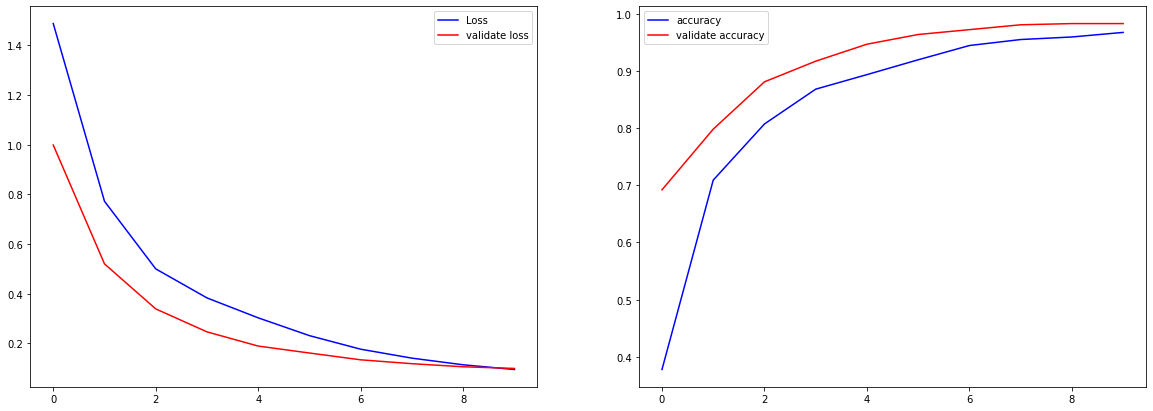

In [ ]:
import matplotlib.pyplot as plt
 
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epoch_scale = range(len(loss))
fig = plt.figure(figsize=(20,7))
ax=fig.add_subplot(1,2,1)
ax.plot(epoch_scale, loss, 'b', label='Training Loss')
ax.plot(epoch_scale, val_loss, 'r', label='Validation Loss')
ax.legend(["Loss", "validate loss"])
ax1=fig.add_subplot(1,2,2)
ax1.plot(epoch_scale, accuracy, 'b', label='Training accuracy')
ax1.plot(epoch_scale, val_accuracy, 'r', label='Validation accuracy')
ax1.legend(["accuracy", "validate accuracy"])

fig.show()

In [ ]:
epochs=10

In [ ]:
initial_epoch=epochs
epochs=epochs+10
history=model_2.fit(train_cubes, validation_data =val_cubes,
                      epochs=epochs,
                      initial_epoch = initial_epoch,
                      # steps_per_epoch=split//batch_size,
                      # validation_steps = int(length - split)//batch_size
                      )

Epoch 11/20
32/32 [==============================] - 35s 1s/step - loss: 0.0781 - accuracy: 0.9746 - val_loss: 0.0911 - val_accuracy: 0.9830
Epoch 12/20
32/32 [==============================] - 38s 1s/step - loss: 0.0657 - accuracy: 0.9800 - val_loss: 0.0906 - val_accuracy: 0.9830
Epoch 13/20
32/32 [==============================] - 36s 1s/step - loss: 0.0569 - accuracy: 0.9830 - val_loss: 0.0928 - val_accuracy: 0.9809
Epoch 14/20
32/32 [==============================] - 37s 1s/step - loss: 0.0490 - accuracy: 0.9850 - val_loss: 0.0907 - val_accuracy: 0.9851
Epoch 15/20
32/32 [==============================] - 37s 1s/step - loss: 0.0404 - accuracy: 0.9890 - val_loss: 0.0887 - val_accuracy: 0.9851
Epoch 16/20
32/32 [==============================] - 37s 1s/step - loss: 0.0321 - accuracy: 0.9940 - val_loss: 0.0892 - val_accuracy: 0.9851
Epoch 17/20
32/32 [==============================] - 37s 1s/step - loss: 0.0259 - accuracy: 0.9945 - val_loss: 0.0904 - val_accuracy: 0.9873
Epoch 18/20
3

In [ ]:
loss=[*loss, *history.history['loss']]
val_loss =[*val_loss, *history.history['val_loss']]
accuracy =[*accuracy, *history.history['accuracy']]
val_accuracy =[*val_accuracy, *history.history['val_accuracy']]
epoch_scale = range(len(loss))


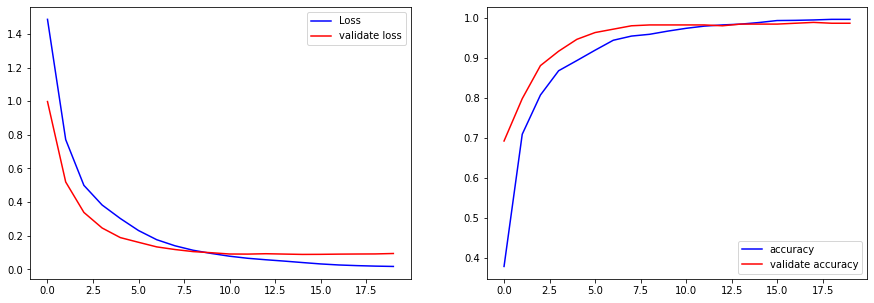

In [ ]:

fig = plt.figure(figsize=(15,5))
ax=fig.add_subplot(1,2,1)
ax.plot(epoch_scale, loss, 'b', label='Training Loss')
ax.plot(epoch_scale, val_loss, 'r', label='Validation Loss')
ax.legend(["Loss", "validate loss"])
ax1=fig.add_subplot(1,2,2)
ax1.plot(epoch_scale, accuracy, 'b', label='Training accuracy')
ax1.plot(epoch_scale, val_accuracy, 'r', label='Validation accuracy')
ax1.legend(["accuracy", "validate accuracy"])

fig.show()

for 20 epochs the same result is getting
so 10 epochs is enaugh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.keras.models.save_model( model_2, '/content/drive/MyDrive/Tahiri Nadia/model_2.h5')

In [ ]:
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/Tahiri Nadia/model_2.h5')

We got 98% accuracy for our 3D images of RF-Matrices, and these images is invariant to the number of trees in the matrices or order of entry of trees to the matrix eather

##Confusion matrix

In [ ]:
ds_test = tf.data.Dataset.from_tensor_slices((test_x,test_y))
ds_test = ds_test.map(to_3DCube)
ds_test = ds_test.map(lambda ind,val,l:[tf.SparseTensor(ind,tf.squeeze(val),(100,100,100)),l])
ds_test= ds_test.map(lambda c,l:[tf.expand_dims(tf.sparse.to_dense(c,default_value=0,validate_indices=False), axis=-1),l])

validation_array = np.array(list(ds_test.as_numpy_iterator()),dtype=object)
test_x = np.stack(validation_array[:,0])
test_y = np.stack(validation_array[:,1])


In [ ]:

# Use the model to predict the labels
test_predictions = model_2.predict(test_x,steps=test_x.shape[0])
test_y_pred = np.argmax(test_predictions, axis=1)
test_y_true = np.argmax(test_y, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
confMat=confusion_matrix( test_y_pred,test_y_true)
print( np.sum(np.diag(confMat))/len(test_y_true))

0.9959677419354839


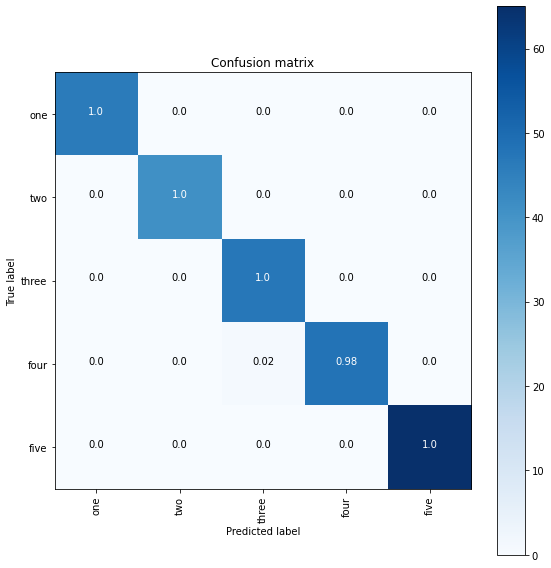

In [ ]:
import itertools
import io
from tensorflow.image import decode_png

def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=90)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  # return figure

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = decode_png(buf.getvalue(), channels=4)
  return image

plot_confusion_matrix(confMat,class_names=('one','two','three','four','five'))

## Checking on real data

In [ ]:
from sklearn.cluster import AffinityPropagation
fh = url.urlopen( 'https://github.com/TahiriNadia/ML_DL_Classification_Trees/raw/master/data/SARS-CoV-2/matrice_SARS-CoV-2')

fh.readline() #frist row
mCOV=[]
#mCOV= np.zeros((12,12)
while True:
  line = fh.readline()
  if not line:
    break
  values_i = np.array(line.split(), dtype=np.float)
  mCOV.append(values_i )
mCOV = np.vstack(mCOV)
mCOV = mCOV/np.max(mCOV)


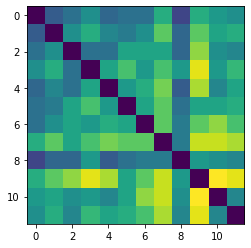

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(mCOV)

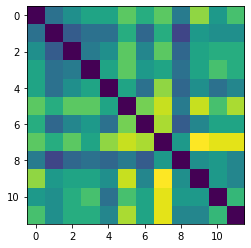

In [ ]:
def permute_RF(expl):
  ind=np.random.permutation(np.arange(expl.shape[0]))
  permuted_trees=expl[ind,:]
  permuted_trees=permuted_trees[:,ind]
  return permuted_trees

permutedCONV =permute_RF(mCOV)
plt.imshow(permutedCONV)

### Our method
Composes two models into a pipeline and are infers a cluster number on model output

In [ ]:
def theMethod(RF_matrix):
  ind,val,_ = to_3DCube(RF_matrix,length = RF_matrix.shape[0] )
  cube = tf.SparseTensor(ind,tf.squeeze(val),(100,100,100))
  cube = tf.expand_dims(
                        tf.sparse.to_dense(cube,default_value=0,validate_indices=False),
                        axis=-1)
  # embeddings= Encoder.predict(np.expand_dims(dist,axis=-1))
  res = model_2.predict(tf.expand_dims(cube,axis=0))
  print(res)
  return np.argmax(res[0])+1


### Affinity Propagation method
Gets input a distance matrix and outputs clastered data
[Affinity Propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation)


AffinityPropagation predicts 4 clusters for mCOV

In [ ]:
from sklearn.cluster import AffinityPropagation
AffinityPropagation().fit_predict(X=mCOV)

array([0, 0, 0, 3, 0, 0, 0, 1, 0, 2, 3, 3])

our method predicts one cluster in mCOV

In [ ]:
np.set_printoptions(precision=2)
theMethod(mCOV)

[[9.87e-01 4.33e-04 7.14e-03 5.56e-03 8.37e-05]]


1

and exactly the same predicts for permutate matrix:

In [ ]:
theMethod(permutedCONV)

[[9.87e-01 4.33e-04 7.14e-03 5.56e-03 8.37e-05]]


1

In [ ]:
def stockhamm_data( input_file ):
  with open(input_file) as f:
    line= f.readline()
    ret = np.vstack([np.array([line.split() for line in f],float)])
  return ret

in this visualisation a part of large real-data rf-matrix (26 trees)  shows two variants of clusterisation: 3 clusters or 2 clusters:

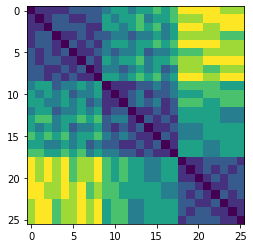

In [ ]:
Casesal = stockhamm_data("/content/drive/MyDrive/Tahiri Nadia/caseal_rf_matrice_RF.txt")
sect_Casesal = Casesal[:26,:26]
sect_Casesal = sect_Casesal/np.max(sect_Casesal)
plt.imshow(sect_Casesal)


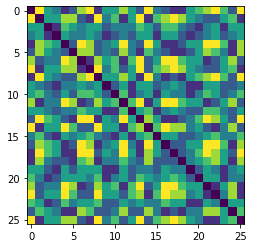

In [ ]:
permuted_Casesal = permute_RF(sect_Casesal)
plt.imshow(permuted_Casesal)

AffinityPropagation predicts 3 clusters for first 26 trees from  rf-matrix "Casesal"

In [ ]:
res = AffinityPropagation(damping=.5).fit_predict(X=sect_Casesal)
print (res)
print(f'Cluster number:{res.max()+1}')

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
Cluster number:3


In [ ]:
res = AffinityPropagation(damping=.5).fit_predict(X=permuted_Casesal)
print (res)
print(f'Cluster number:{res.max()+1}')

[0 2 1 1 0 0 2 2 0 1 1 2 1 0 2 1 0 0 0 1 1 2 2 1 0 2]
Cluster number:3


Our method is confident in predict of 2 clusters for the first 26 trees from "Casesal"

In [ ]:
# model.load_weights('/content/drive/MyDrive/Tahiri Nadia/small_model1_weights.h5')
print(f'Casesal:{theMethod(sect_Casesal)} clusters')
print(f'permuted_Casesal:{theMethod(permuted_Casesal)}  clusters')

[[1.14e-04 1.00e+00 9.18e-05 1.43e-05 1.31e-09]]
Casesal:2 clusters
[[1.14e-04 1.00e+00 9.18e-05 1.43e-05 1.31e-09]]
permuted_Casesal:2  clusters


##test the model of Woese dataset

In [ ]:
!pip install git+git://github.com/jeetsukumaran/DendroPy.git

import dendropy

  Cloning git://github.com/jeetsukumaran/DendroPy.git to /tmp/pip-req-build-fdiu1q7f
  Running command git clone -q git://github.com/jeetsukumaran/DendroPy.git /tmp/pip-req-build-fdiu1q7f
  Created wheel for DendroPy: filename=DendroPy-4.5.2-cp37-none-any.whl size=453788 sha256=f6822d8944586a3f97038a8ae5d3dee1b1af01ef40c10945f83577ac667cbb19
  Stored in directory: /tmp/pip-ephem-wheel-cache-3m3osfg3/wheels/cc/bb/7c/76764a8aef152bc6d44e91d4de0769e29da5f88e69b7628e35
Successfully built DendroPy


In [ ]:
Woese_newick ='https://github.com/TahiriNadia/ML_DL_Classification_Trees/raw/master/data/Woese/all_trees_woese.txt'
# Woese_newick = 'https://raw.githubusercontent.com/TahiriNadia/ML_DL_Classification_Trees/master/data/Woese/all_trees_woese.txt'

In [ ]:
tree_list = dendropy.TreeList.get(
    url=Woese_newick,
    schema="newick",
    taxon_namespace = dendropy.TaxonNamespace()
)

In [ ]:
from dendropy.calculate import treecompare
Woese_RF = np.array([[treecompare.robinson_foulds_distance(tree1,tree2) for tree2 in tree_list] for tree1 in tree_list])

In [ ]:
Woese_RF=Woese_RF/np.max(Woese_RF)

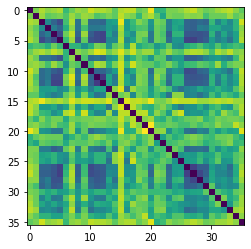

In [ ]:
plt.imshow(Woese_RF)

by our method

In [ ]:
print(f'Cluster number:{theMethod(Woese_RF)}')

[[1.00e+00 8.47e-08 4.70e-09 1.01e-08 5.94e-12]]
Cluster number:1


by affinity propogation method

In [ ]:
res = AffinityPropagation(damping=.5).fit_predict(X=Woese_RF)
print (res)
print(f'Cluster number:{res.max()+1}')

[2 2 4 4 4 4 3 2 4 2 4 4 4 3 0 1 3 0 2 2 4 2 2 0 3 3 4 4 4 4 3 0 3 4 0 2]
Cluster number:5
